## Dynamic Risk Budgeting

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import edhec_risk_kit as erk
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
n_scenarios = 5000
rates, zc_prices = erk.cir(10, n_scenarios=n_scenarios, b=0.03, r_0=0.03, sigma=0.02)
price_eq = erk.gbm(n_years=10, n_scenarios=n_scenarios, mu=0.07, sigma=0.15)

In [30]:
# Using zero-coupon bonds as a proxy for a duration matched portfolio

rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_7030b = erk.bt_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1=0.70)
pd.concat([
    erk.terminal_stats(rets_zc, name="ZC Bonds", floor=0.75),
    erk.terminal_stats(rets_eq, name="Equities", floor=0.75),
    erk.terminal_stats(rets_7030b, name="70eq/30b", floor=0.75)
], axis=1).round(2)

# Unable to solve the breach problem

,ZC Bonds,Equities,70eq/30b
mean,1.34,1.98,1.76
std,0.00,0.99,0.60
p_breach,NaN,0.04,0.01
e_short,NaN,0.12,0.08
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


In [38]:
rets_eq.shape

(120, 5000)

In [51]:

rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_floor75 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:])
pd.concat([erk.terminal_stats(rets_zc, name="ZC Bonds", floor=0.75),
           erk.terminal_stats(rets_eq, name="Equities", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70eq/30b", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75)
          ], 
          axis=1).round(2)

,ZC Bonds,Equities,70eq/30b,Floor75
mean,1.34,1.98,1.76,1.95
std,0.00,0.99,0.60,0.99
p_breach,NaN,0.04,0.01,NaN
e_short,NaN,0.12,0.08,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


In [55]:
rets_floor75m1 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:], m=1)
rets_floor75m5 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:], m=5)
pd.concat([erk.terminal_stats(rets_zc, name="ZC Bonds", floor=0.75),
           erk.terminal_stats(rets_eq, name="Equities", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70eq/30b", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           erk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
           erk.terminal_stats(rets_floor75m5, name="Floor75m5", floor=0.75)
          ], 
          axis=1).round(2)


,ZC Bonds,Equities,70eq/30b,Floor75,Floor75m1,Floor75m5
mean,1.34,1.98,1.76,1.95,1.63,1.96
std,0.00,0.99,0.60,0.99,0.44,1.00
p_breach,NaN,0.04,0.01,NaN,NaN,NaN
e_short,NaN,0.12,0.08,NaN,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
pd.concat([erk.terminal_stats(rets_zc, name="ZC Bonds", floor=0.75),
           erk.terminal_stats(rets_eq, name="Equities", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70eq/30b", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           erk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
           erk.terminal_stats(rets_floor75m5, name="Floor75m5", floor=0.75)
          ], 
          axis='columns').round(4)  # axis ='columns' or =1, same thing

,ZC Bonds,Equities,70eq/30b,Floor75,Floor75m1,Floor75m5
mean,1.3433,1.9772,1.7611,1.9533,1.6252,1.9640
std,0.0000,0.9879,0.6000,0.9927,0.4360,0.9951
p_breach,NaN,0.0382,0.0086,NaN,NaN,NaN
e_short,NaN,0.1211,0.0795,NaN,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN


## Risk Budgeting with Drawdown Constraint

In [59]:
cashrate = 0.02
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data = monthly_cashreturn, index = rets_eq.index, columns = rets_eq.columns)
rets_maxdd25 = erk.bt_mix(rets_eq, rets_cash, allocator=erk.drawdown_allocator, maxdd=0.25)
tv_maxdd25 = erk.terminal_values(rets_maxdd25)
pd.concat([erk.terminal_stats(rets_zc, name="ZC Bonds", floor=0.75),
           erk.terminal_stats(rets_eq, name="Equities", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70eq/30b", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           erk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
           erk.terminal_stats(rets_floor75m5, name="Floor75m5", floor=0.75),
           erk.terminal_stats(rets_maxdd25, name="MaxDD25", floor=0.75)
          ], 
          axis='columns').round(4)  # axis ='columns' or =1, same thing

,ZC Bonds,Equities,70eq/30b,Floor75,Floor75m1,Floor75m5,MaxDD25
mean,1.3433,1.9772,1.7611,1.9533,1.6252,1.9640,1.6335
std,0.0000,0.9879,0.6000,0.9927,0.4360,0.9951,0.5438
p_breach,NaN,0.0382,0.0086,NaN,NaN,NaN,NaN
e_short,NaN,0.1211,0.0795,NaN,NaN,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
erk.summary_stats(rets_maxdd25)["Max Drawdown"].head()

0   -0.216407
1   -0.174722
2   -0.170049
3   -0.171414
4   -0.177675
Name: Max Drawdown, dtype: float64

In [61]:
erk.summary_stats(rets_maxdd25)["Max Drawdown"].min()

-0.2346049744044271

C:\Users\Michael\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Michael\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Michael\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an ax

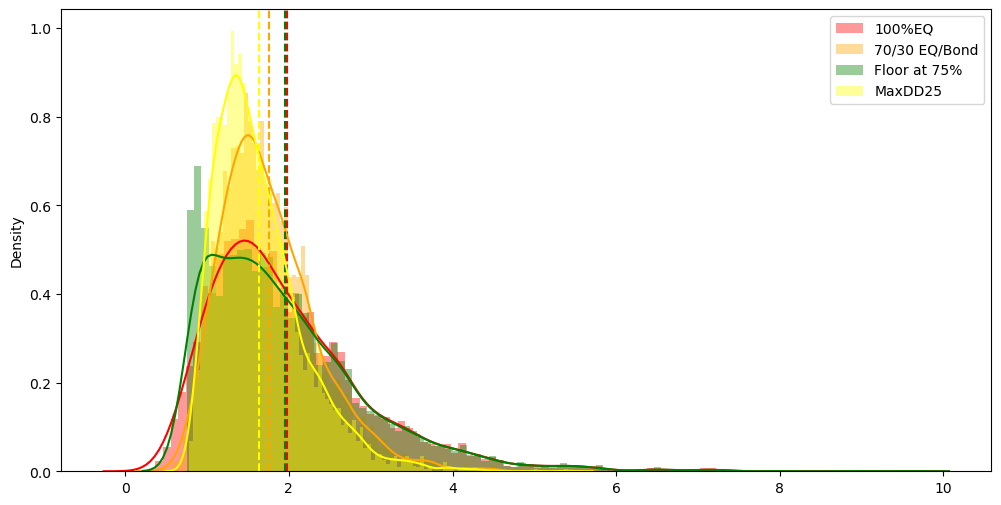

In [64]:
# Plot 

tv_eq = erk.terminal_values(rets_eq)
tv_zc = erk.terminal_values(rets_zc)
tv_7030b = erk.terminal_values(rets_7030b)
tv_floor75 = erk.terminal_values(rets_floor75)
tv_maxdd = erk.terminal_values(rets_maxdd25)

plt.figure(figsize=(12,6))
sns.distplot(tv_eq, color="red", label="100%EQ", bins=100)
plt.axvline(tv_eq.mean(), ls="--", color="red")
sns.distplot(tv_7030b, color="orange", label="70/30 EQ/Bond", bins=100)
plt.axvline(tv_7030b.mean(), ls="--", color="orange")
sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)
plt.axvline(tv_floor75.mean(), ls="--", color="green")
sns.distplot(tv_maxdd25, color="yellow", label="MaxDD25", bins=100)
plt.axvline(tv_maxdd25.mean(), ls="--", color="yellow")
plt.legend();

## Drawdown Constraint with Historical Data

<AxesSubplot:>

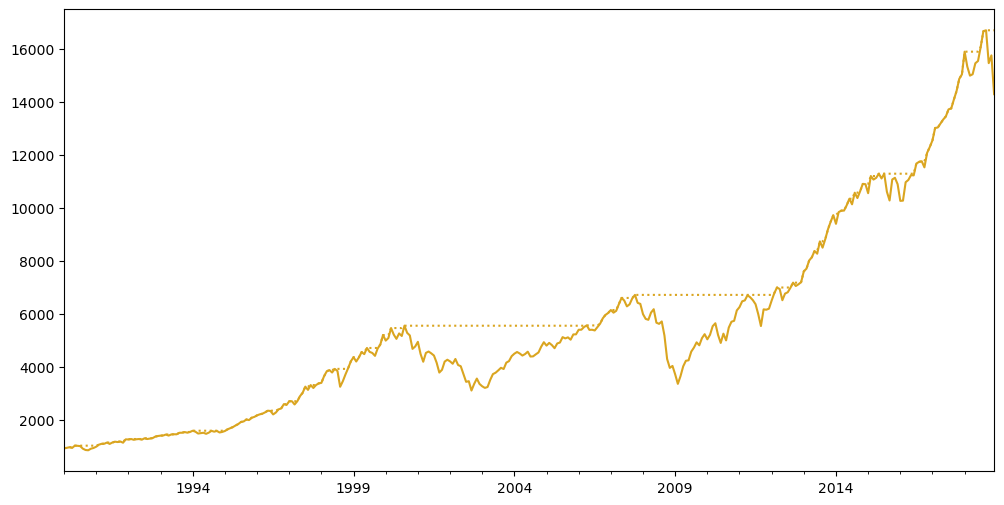

In [65]:
rets_tmi = erk.get_total_market_index_returns()["1990":]
dd_tmi = erk.drawdown(rets_tmi)
ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod")
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod")

<AxesSubplot:>

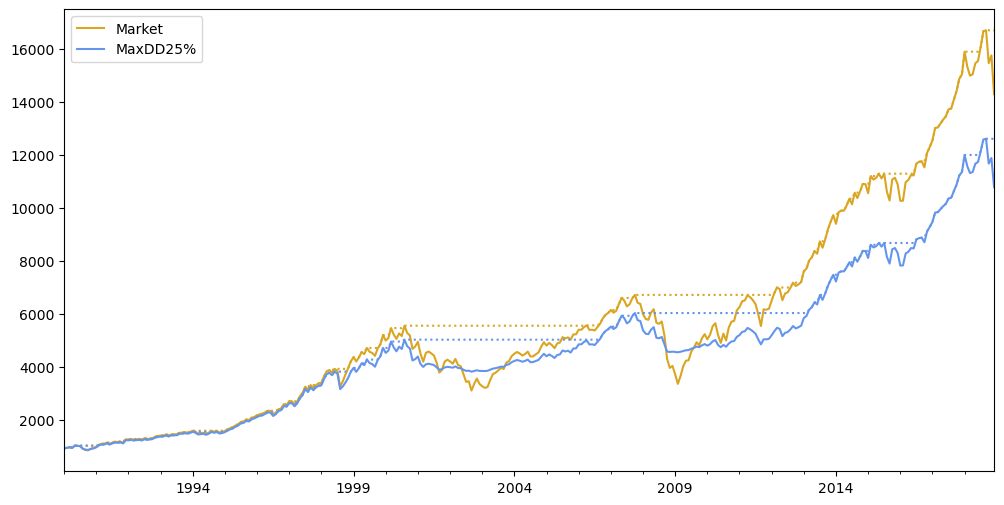

In [66]:
cash_rate = 0.3
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data=monthly_cashreturn, index=rets_tmi.index, columns=[0]) # 1 column datafram
rets_maxdd25 = erk.bt_mix(pd.DataFrame(rets_tmi), rets_cash, allocator=erk.drawdown_allocator, maxdd=0.25, m=5) # KEY..Historical Data..not simulated data
dd_25 = erk.drawdown(rets_maxdd25[0])

ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod", label="Market", legend=True)
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod")
dd_25["Wealth"].plot(ax=ax, label="MaxDD25%", color="cornflowerblue", legend=True)
dd_25["Previous Peak"].plot(ax=ax, ls=":", color="cornflowerblue")


In [67]:
erk.summary_stats(pd.concat([rets_tmi.rename("Market"), rets_maxdd25[0].rename("MaxDD")], axis=1))

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Market,0.096058,0.145419,-0.668827,4.247282,0.066949,0.094633,0.441951,-0.499943
MaxDD,0.085443,0.110355,-0.613382,5.306415,0.048799,0.069862,0.488861,-0.245579
